In [7]:
# Setup: install helpful libraries
!pip -q install gdown pandas numpy matplotlib scipy statsmodels scikit-learn pyarrow openpyxl

import os, json, zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.formula.api as smf

BASE = "."
CSV_DIR = os.path.join(BASE, "csv_files")
OUT_DIR = os.path.join(BASE, "outputs")
os.makedirs(CSV_DIR, exist_ok=True)
os.makedirs(OUT_DIR, exist_ok=True)
print("ready:", CSV_DIR, OUT_DIR)


ready: ./csv_files ./outputs


In [8]:
import gdown, os

HIST_ID = "1IAfLZwu6rJzyWKgBToqwSmmVYU6VbjVs"  # update if your link changes
FG_ID   = "1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf"

def gdown_try_all(file_id, out_base):
    for ext in (".csv",".parquet",".xlsx",".zip"):
        url = f"https://drive.google.com/uc?id={file_id}"
        out = os.path.join(CSV_DIR, out_base + ext)
        try:
            gdown.download(url, out, quiet=False)
            if os.path.exists(out) and os.path.getsize(out) > 0:
                print("downloaded:", out)
                return out
        except Exception as e:
            print("try", ext, "->", e)
    raise RuntimeError("download failed; make sure sharing is 'Anyone with the link can view'.")

hist_path = gdown_try_all(HIST_ID, "historical_trades")
fg_path   = gdown_try_all(FG_ID,   "fear_greed")
hist_path, fg_path


Downloading...
From: https://drive.google.com/uc?id=1IAfLZwu6rJzyWKgBToqwSmmVYU6VbjVs
To: /content/csv_files/historical_trades.csv
100%|██████████| 47.5M/47.5M [00:00<00:00, 56.6MB/s]


downloaded: ./csv_files/historical_trades.csv


Downloading...
From: https://drive.google.com/uc?id=1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf
To: /content/csv_files/fear_greed.csv
100%|██████████| 90.8k/90.8k [00:00<00:00, 46.0MB/s]

downloaded: ./csv_files/fear_greed.csv


('./csv_files/historical_trades.csv', './csv_files/fear_greed.csv')

In [9]:
def robust_load(path):
    if path.endswith(".csv"):
        return pd.read_csv(path)
    if path.endswith(".parquet"):
        return pd.read_parquet(path)
    if path.endswith(".xlsx"):
        return pd.read_excel(path)
    if path.endswith(".zip"):
        with zipfile.ZipFile(path, "r") as z:
            names = z.namelist()
            inner = [n for n in names if n.lower().endswith((".csv",".parquet",".xlsx"))]
            assert inner, "no csv/parquet/excel inside zip"
            name = inner[0]
            if name.lower().endswith(".csv"):
                return pd.read_csv(z.open(name))
            elif name.lower().endswith(".parquet"):
                tmp = os.path.join(CSV_DIR, "_tmp.parquet")
                with open(tmp, "wb") as f: f.write(z.read(name))
                df = pd.read_parquet(tmp); os.remove(tmp); return df
            else:
                tmp = os.path.join(CSV_DIR, "_tmp.xlsx")
                with open(tmp, "wb") as f: f.write(z.read(name))
                df = pd.read_excel(tmp); os.remove(tmp); return df
    raise ValueError(f"unsupported file: {path}")

hist = robust_load(hist_path)
fg   = robust_load(fg_path)

print("hist shape:", hist.shape); display(hist.head(3))
print("fg shape:", fg.shape);     display(fg.head(3))


hist shape: (211224, 16)


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12


fg shape: (2644, 4)


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03


In [10]:
# normalize column names
hist.columns = [c.strip().lower().replace(" ", "_") for c in hist.columns]
fg.columns   = [c.strip().lower().replace(" ", "_") for c in fg.columns]

# pick the time column in the trades data
time_candidates = [c for c in ("time","timestamp","executed_at","trade_time") if c in hist.columns]
assert time_candidates, f"no time column found in: {hist.columns.tolist()}"
ts_col = time_candidates[0]
hist[ts_col] = pd.to_datetime(hist[ts_col], errors="coerce", utc=True)
hist["date"] = hist[ts_col].dt.date  # UTC calendar day

# make numeric
for c in ("execution_price","size","closedpnl","leverage","start_position"):
    if c in hist.columns:
        # handle strings like "10x"
        hist[c] = pd.to_numeric(str(hist[c].dtype)=="object" and hist[c].astype(str).str.replace("x","",case=False,regex=False) or hist[c], errors="coerce")

# side -> long/short flag (optional but handy)
if "side" in hist.columns:
    hist["side"] = hist["side"].astype(str).str.lower().str.strip()
    hist["is_long"] = hist["side"].isin(["buy","long","open_long","close_short"]).astype(int)

# fear/greed dataset standardization
fg_date_col = "date" if "date" in fg.columns else fg.columns[0]
fg[fg_date_col] = pd.to_datetime(fg[fg_date_col], errors="coerce").dt.date

cls_col = "classification" if "classification" in fg.columns else (
    "class" if "class" in fg.columns else [c for c in fg.columns if c != fg_date_col][0]
)

fg["sentiment"] = np.where(fg[cls_col].astype(str).str.contains("greed", case=False), "Greed",
                    np.where(fg[cls_col].astype(str).str.contains("fear", case=False), "Fear", "Unknown"))
fg = fg[[fg_date_col, "sentiment"]].rename(columns={fg_date_col:"date"})
display(fg.head())


,date,sentiment
0,2018-02-01,Fear
1,2018-02-02,Fear
2,2018-02-03,Fear
3,2018-02-04,Fear
4,2018-02-05,Fear


In [13]:
# We already have merged with 'sentiment' and a 'date' column in your data.
# If you haven't merged yet, ensure 'merged = hist.merge(fg, on="date", how="left")'
# But from your columns list, it seems 'sentiment' is already present.

# 1) Notional USD: you already have size_usd — use that directly.
if "size_usd" in merged.columns:
    merged["notional_usd"] = pd.to_numeric(merged["size_usd"], errors="coerce").abs()
else:
    # fallback: price * size_tokens if size_usd missing
    merged["notional_usd"] = (
        pd.to_numeric(merged.get("execution_price", np.nan), errors="coerce").abs()
        * pd.to_numeric(merged.get("size_tokens", np.nan), errors="coerce").abs()
    )

# 2) Win flag from closed_pnl
if "closed_pnl" in merged.columns:
    merged["closed_pnl"] = pd.to_numeric(merged["closed_pnl"], errors="coerce")
    merged["is_win"] = (merged["closed_pnl"] > 0).astype(int)
else:
    merged["is_win"] = np.nan

# 3) (Optional) Direction sanity: you already have is_long, so we keep it as-is.
# 4) Keep only sensible rows (optional): drop rows without date or sentiment
merged = merged.dropna(subset=["date", "sentiment"]).copy()

merged.head(5)


,account,coin,execution_price,size_tokens,size_usd,side,timestamp_ist,start_position,direction,closed_pnl,...,order_id,crossed,fee,trade_id,timestamp,date,is_long,sentiment,notional_usd,is_win
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,buy,02-12-2024 22:50,0.000000,Buy,0.0,...,52017706630,True,0.345404,8.950000e+14,1970-01-01 00:28:50+00:00,1970-01-01,1,Unknown,7872.16,0
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,buy,02-12-2024 22:50,986.524596,Buy,0.0,...,52017706630,True,0.005600,4.430000e+14,1970-01-01 00:28:50+00:00,1970-01-01,1,Unknown,127.68,0
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,buy,02-12-2024 22:50,1002.518996,Buy,0.0,...,52017706630,True,0.050431,6.600000e+14,1970-01-01 00:28:50+00:00,1970-01-01,1,Unknown,1150.63,0
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,buy,02-12-2024 22:50,1146.558564,Buy,0.0,...,52017706630,True,0.050043,1.080000e+15,1970-01-01 00:28:50+00:00,1970-01-01,1,Unknown,1142.04,0
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,buy,02-12-2024 22:50,1289.488521,Buy,0.0,...,52017706630,True,0.003055,1.050000e+15,1970-01-01 00:28:50+00:00,1970-01-01,1,Unknown,69.75,0


In [20]:
import pandas as pd

# 1) Parse the IST string timestamp (format: DD-MM-YYYY HH:MM)
hist["timestamp_ist"] = pd.to_datetime(
    hist["timestamp_ist"],
    format="%d-%m-%Y %H:%M",  # matches "02-12-2024 22:50"
    errors="coerce"
)

# 2) Localize to IST, convert to UTC
hist["ts_utc"] = (
    hist["timestamp_ist"]
    .dt.tz_localize("Asia/Kolkata")
    .dt.tz_convert("UTC")
)

# 3) Use the UTC calendar date for the merge
hist["date"] = hist["ts_utc"].dt.date

# Quick sanity check
print(hist[["timestamp_ist","ts_utc","date"]].head(10))
print("date range:", hist["date"].min(), "→", hist["date"].max())


        timestamp_ist                    ts_utc        date
0 2024-12-02 22:50:00 2024-12-02 17:20:00+00:00  2024-12-02
1 2024-12-02 22:50:00 2024-12-02 17:20:00+00:00  2024-12-02
2 2024-12-02 22:50:00 2024-12-02 17:20:00+00:00  2024-12-02
3 2024-12-02 22:50:00 2024-12-02 17:20:00+00:00  2024-12-02
4 2024-12-02 22:50:00 2024-12-02 17:20:00+00:00  2024-12-02
5 2024-12-02 22:50:00 2024-12-02 17:20:00+00:00  2024-12-02
6 2024-12-02 22:50:00 2024-12-02 17:20:00+00:00  2024-12-02
7 2024-12-02 22:50:00 2024-12-02 17:20:00+00:00  2024-12-02
8 2024-12-02 22:50:00 2024-12-02 17:20:00+00:00  2024-12-02
9 2024-12-02 22:50:00 2024-12-02 17:20:00+00:00  2024-12-02
date range: 2023-04-30 → 2025-05-01


In [21]:
merged = hist.merge(fg, on="date", how="left")
merged["sentiment"] = merged["sentiment"].fillna("Unknown")
merged["sentiment"].value_counts(dropna=False)


,count
sentiment,
Greed,88848
Fear,82813
Unknown,39563


In [22]:
import numpy as np

# Use existing USD size if available; else fallback to price * size_tokens
if "size_usd" in merged.columns:
    merged["notional_usd"] = pd.to_numeric(merged["size_usd"], errors="coerce").abs()
else:
    merged["notional_usd"] = (
        pd.to_numeric(merged.get("execution_price", np.nan), errors="coerce").abs()
        * pd.to_numeric(merged.get("size_tokens", np.nan), errors="coerce").abs()
    )

# Win flag
merged["closed_pnl"] = pd.to_numeric(merged.get("closed_pnl", np.nan), errors="coerce")
merged["is_win"] = (merged["closed_pnl"] > 0).astype(int)


In [23]:
agg_keys = ["account","date","sentiment"]
agg_map = {
    "closed_pnl": "sum",
    "is_win": "mean",
    "notional_usd": "sum"
}
for k in list(agg_map.keys()):
    if k not in merged.columns:
        agg_map.pop(k, None)

account_daily = (
    merged
    .groupby(agg_keys).agg(agg_map).reset_index()
    .rename(columns={
        "closed_pnl":"daily_pnl",
        "is_win":"winrate",
        "notional_usd":"volume_usd"
    })
)

# Save (optional)
account_daily.to_csv(os.path.join(CSV_DIR, "account_daily_metrics.csv"), index=False)
merged.to_csv(os.path.join(CSV_DIR, "merged_trades_with_sentiment.csv"), index=False)

account_daily.head(5)


,account,date,sentiment,daily_pnl,winrate,volume_usd
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-11,Greed,0.0,0.000000,900880.13
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-17,Greed,0.0,0.000000,542413.18
2,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-18,Greed,0.0,0.000000,949380.00
3,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-22,Greed,-21227.0,0.000000,338240.00
4,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-26,Greed,1603.1,0.444444,465700.00


,count,mean,std,min,25%,50%,75%,max
sentiment,,,,,,,,
Fear,789.0,4994.106565,30156.184300,-108604.496278,0.0,153.845757,2129.255844,533974.662903
Greed,1181.0,4279.918783,29422.854885,-356547.173670,0.0,263.886914,1764.111388,420021.176043
Unknown,373.0,3490.683061,17617.683321,-122145.576660,0.0,178.567901,1140.403256,192278.174753


daily_pnl: Mann–Whitney U p=0.2021
saved: ./outputs/daily_pnl_by_sentiment.png


,count,mean,std,min,25%,50%,75%,max
sentiment,,,,,,,,
Fear,789.0,763973.307174,3.180826e+06,0.01,17189.07,84001.13,331808.01,44219106.64
Greed,1181.0,335877.038552,1.673264e+06,0.00,16712.87,64536.59,206118.29,42080895.32
Unknown,373.0,514052.870161,2.668826e+06,0.01,14406.83,70567.97,278268.72,40045867.65


volume_usd: Mann–Whitney U p=0.008042
saved: ./outputs/volume_usd_by_sentiment.png


,count,mean,std,min,25%,50%,75%,max
sentiment,,,,,,,,
Fear,789.0,0.370160,0.352402,0.0,0.0,0.321023,0.619048,1.0
Greed,1181.0,0.360130,0.341155,0.0,0.0,0.320755,0.598746,1.0
Unknown,373.0,0.354082,0.331169,0.0,0.0,0.333333,0.596774,1.0


winrate: Mann–Whitney U p=0.6484
saved: ./outputs/winrate_by_sentiment.png


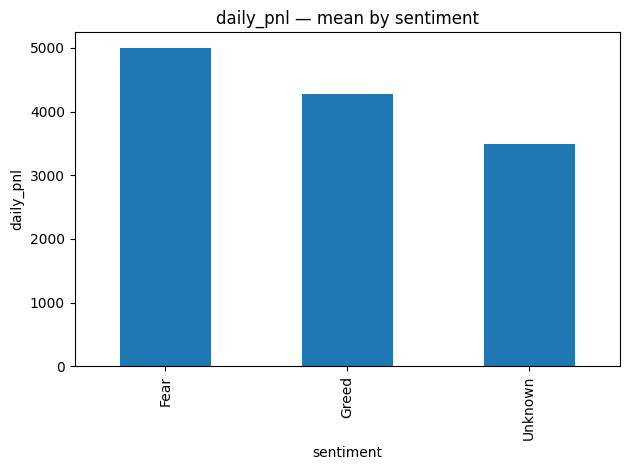

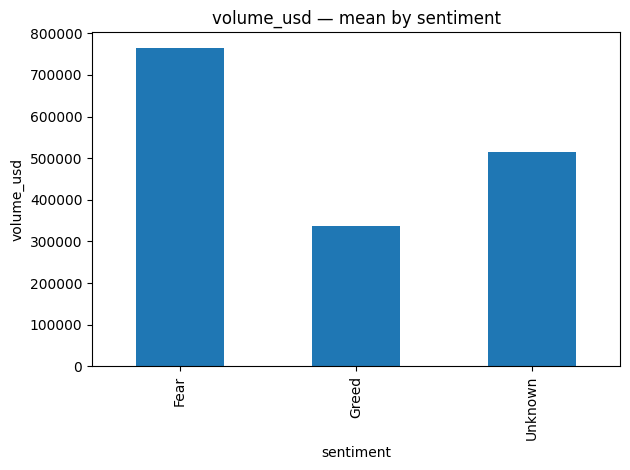

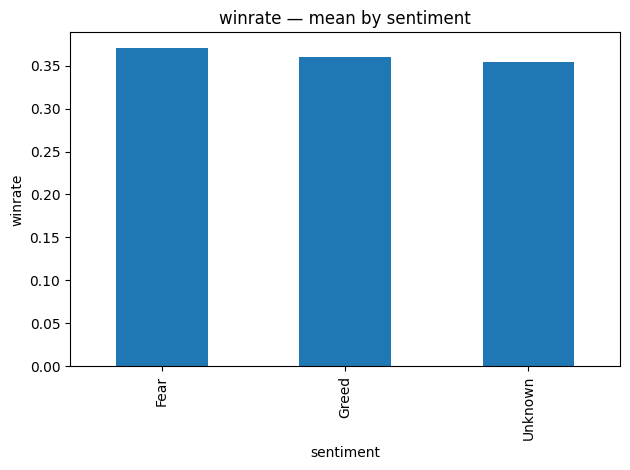

In [24]:
def describe_by_sent(df, metric, outname):
    df = df.dropna(subset=[metric, "sentiment"])
    # summary table
    display(df.groupby("sentiment")[metric].describe())
    # Greed vs Fear significance
    g = df.loc[df["sentiment"]=="Greed", metric].dropna()
    f = df.loc[df["sentiment"]=="Fear",  metric].dropna()
    if len(g) > 5 and len(f) > 5:
        from scipy import stats
        stat, p = stats.mannwhitneyu(g, f, alternative="two-sided")
        print(f"{metric}: Mann–Whitney U p={p:.4g}")
    # mean bar plot
    plt.figure()
    df.groupby("sentiment")[metric].mean().plot(kind="bar", title=f"{metric} — mean by sentiment")
    plt.ylabel(metric); plt.tight_layout()
    path = os.path.join(OUT_DIR, outname)
    plt.savefig(path, dpi=160)
    print("saved:", path)

for m in ("daily_pnl","volume_usd","winrate"):
    if m in account_daily.columns:
        describe_by_sent(account_daily, m, f"{m}_by_sentiment.png")


In [25]:
import json, os

kpis = {}
for col in ("daily_pnl","volume_usd","winrate"):
    if col in account_daily.columns:
        kpis[col] = account_daily.groupby("sentiment")[col].mean().round(4).to_dict()

# also add medians (robust to outliers)
for col in ("daily_pnl","volume_usd","winrate"):
    if col in account_daily.columns:
        med_key = f"{col}_median"
        kpis[med_key] = account_daily.groupby("sentiment")[col].median().round(4).to_dict()

out_path = os.path.join(CSV_DIR, "kpi_by_sentiment.json")
with open(out_path, "w") as f:
    json.dump(kpis, f, indent=2)
print("Saved:", out_path)
kpis


Saved: ./csv_files/kpi_by_sentiment.json


{'daily_pnl': {'Fear': 4994.1066, 'Greed': 4279.9188, 'Unknown': 3490.6831},
 'volume_usd': {'Fear': 763973.3072,
  'Greed': 335877.0386,
  'Unknown': 514052.8702},
 'winrate': {'Fear': 0.3702, 'Greed': 0.3601, 'Unknown': 0.3541},
 'daily_pnl_median': {'Fear': 153.8458,
  'Greed': 263.8869,
  'Unknown': 178.5679},
 'volume_usd_median': {'Fear': 84001.13,
  'Greed': 64536.59,
  'Unknown': 70567.97},
 'winrate_median': {'Fear': 0.321, 'Greed': 0.3208, 'Unknown': 0.3333}}

In [26]:
import numpy as np

summary = {}

# coverage
summary["date_min"] = str(pd.to_datetime(merged["date"]).min())
summary["date_max"] = str(pd.to_datetime(merged["date"]).max())
summary["n_trades"] = int(len(merged))
summary["n_accounts"] = int(merged["account"].nunique())
summary["n_symbols"] = int(merged["coin"].nunique()) if "coin" in merged.columns else None

# per-sentiment counts
summary["trades_by_sentiment"] = merged["sentiment"].value_counts().to_dict()

# performance deltas (means & medians)
def make_delta(metric):
    out = {}
    if metric in account_daily.columns:
        g = account_daily.loc[account_daily["sentiment"]=="Greed", metric]
        f = account_daily.loc[account_daily["sentiment"]=="Fear",  metric]
        if len(g) and len(f):
            out["greed_mean"]  = float(np.nanmean(g))
            out["fear_mean"]   = float(np.nanmean(f))
            out["mean_delta"]  = float(out["greed_mean"] - out["fear_mean"])
            out["greed_median"]= float(np.nanmedian(g))
            out["fear_median"] = float(np.nanmedian(f))
            out["median_delta"]= float(out["greed_median"] - out["fear_median"])
    return out

summary["daily_pnl"]  = make_delta("daily_pnl")
summary["winrate"]    = make_delta("winrate")
summary["volume_usd"] = make_delta("volume_usd")

# significance tests (Greed vs Fear) for each metric
from scipy import stats
def mwu_p(metric):
    if metric in account_daily.columns:
        g = account_daily.loc[account_daily["sentiment"]=="Greed", metric].dropna()
        f = account_daily.loc[account_daily["sentiment"]=="Fear",  metric].dropna()
        if len(g)>5 and len(f)>5:
            _, p = stats.mannwhitneyu(g, f, alternative="two-sided")
            return float(p)
    return None

summary["p_values"] = {
    "daily_pnl": mwu_p("daily_pnl"),
    "winrate":   mwu_p("winrate"),
    "volume_usd":mwu_p("volume_usd"),
}

summary


{'date_min': '2023-04-30 00:00:00',
 'date_max': '2025-05-01 00:00:00',
 'n_trades': 211224,
 'n_accounts': 32,
 'n_symbols': 246,
 'trades_by_sentiment': {'Greed': 88848, 'Fear': 82813, 'Unknown': 39563},
 'daily_pnl': {'greed_mean': 4279.918782543607,
  'fear_mean': 4994.106564709759,
  'mean_delta': -714.1877821661519,
  'greed_median': 263.886914,
  'fear_median': 153.845757,
  'median_delta': 110.041157},
 'winrate': {'greed_mean': 0.3601302590268361,
  'fear_mean': 0.3701601504128337,
  'mean_delta': -0.01002989138599758,
  'greed_median': 0.32075471698113206,
  'fear_median': 0.3210227272727273,
  'median_delta': -0.00026801029159523315},
 'volume_usd': {'greed_mean': 335877.0385520745,
  'fear_mean': 763973.3071736376,
  'mean_delta': -428096.26862156304,
  'greed_median': 64536.590000000004,
  'fear_median': 84001.13,
  'median_delta': -19464.54},
 'p_values': {'daily_pnl': 0.20212944610131733,
  'winrate': 0.6484197883517302,
  'volume_usd': 0.008042448600742226}}

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report

df = merged.copy()
df["is_win"] = (pd.to_numeric(df["closed_pnl"], errors="coerce") > 0).astype(int)
df["sentiment_greed"] = (df["sentiment"]=="Greed").astype(int)
df["notional_usd"] = pd.to_numeric(df["notional_usd"], errors="coerce")
df = df.dropna(subset=["is_win","sentiment_greed","notional_usd"])

X = df[["sentiment_greed","notional_usd"]].fillna(0)  # no leverage in your data
y = df["is_win"].astype(int)

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
clf = LogisticRegression(max_iter=200).fit(Xtr, ytr)
proba = clf.predict_proba(Xte)[:,1]
auc = roc_auc_score(yte, proba)
print("AUC:", round(auc, 4))
print(classification_report(yte, clf.predict(Xte)))
with open(os.path.join(OUT_DIR, "logreg_metrics.txt"), "w") as f:
    f.write(f"AUC: {auc:.4f}\n")
    f.write(classification_report(yte, clf.predict(Xte)))
print("Saved:", os.path.join(OUT_DIR, "logreg_metrics.txt"))


AUC: 0.5076
              precision    recall  f1-score   support

           0       0.59      1.00      0.74     24871
           1       0.33      0.00      0.00     17374

    accuracy                           0.59     42245
   macro avg       0.46      0.50      0.37     42245
weighted avg       0.48      0.59      0.44     42245

Saved: ./outputs/logreg_metrics.txt
